<a class="anchor" id="4" name="4"></a>
## **1. Import**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns
import pickle
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import urllib.request

In [3]:
path = '/content/drive/MyDrive/CV++'
train_path = path + '/cityscapes_data/train'
val_path = path + '/cityscapes_data/val'

In [4]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

<a class="anchor" id="2" name="2"></a>
## **2. Prepare data**

In [5]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)

    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array

    return image, mask

def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)

    return closest_category

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask

In [6]:
def preprocess(path, img_size):
    image, mask = image_mask_split(path, img_size)
    mask_enc = find_closest_labels_vectorized(mask, id2color)
    return image, mask_enc, mask

In [7]:
# save processed data to file for future use
def save_list_to_file(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

### 2.1. Mapping

In [8]:
from collections import namedtuple
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'
          , 8       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]
mapping_20 = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 8,
        9: 1,
        10: 1,
        11: 2,
        12: 2,
        13: 2,
        14: 2,
        15: 2,
        16: 2,
        17: 3,
        18: 3,
        19: 3,
        20: 3,
        21: 4,
        22: 4,
        23: 5,
        24: 6,
        25: 6,
        26: 7,
        27: 7,
        28: 7,
        29: 7,
        30: 7,
        31: 7,
        32: 7,
        33: 7,
        -1: 7
    }

In [9]:
BATCH_SIZE = 32
id2color = { label.id : np.asarray(label.color) for label in labels }
num_classes = len(id2color.keys())
width, height = 128, 128
IMAGE_SIZE = [width, height]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

### 2.2. Preprocess data

In [10]:
# Store the images, the masks, and the encoded masks
train_images = []
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

In [11]:
# train_images = np.zeros((2975,256,256,3) )
# train_masks_enc = np.zeros((2975,256,256))
# val_images = np.zeros((250,256,256,3))
# val_masks_enc = np.zeros((250,256,256))
# train_images.shape

In [12]:
# for train_file in tqdm(os.listdir(train_path), desc = 'Building Training Dataset: '):
#     image, mask_enc, mask = preprocess(os.path.join(train_path, train_file), IMAGE_SIZE)
#     train_images.append(image)
#     train_masks.append(mask)
#     train_masks_enc.append(mask_enc)

# for val_file in tqdm(os.listdir(val_path), desc = 'Building Validation Dataset: '):
#     image, mask_enc, mask = preprocess(os.path.join(val_path, val_file), IMAGE_SIZE)
#     val_images.append(image)
#     val_masks.append(mask)
#     val_masks_enc.append(mask_enc)

### 2.3. Save data

In [13]:
# save_list_to_file(train_images, '/content/drive/MyDrive/CV++/data/train_images.pkl')
# save_list_to_file(train_masks, '/content/drive/MyDrive/CV++/data/train_masks.pkl')
# save_list_to_file(train_masks_enc, '/content/drive/MyDrive/CV++/data/train_masks_enc.pkl')

# save_list_to_file(val_images, '/content/drive/MyDrive/CV++/data/val_images.pkl')
# save_list_to_file(val_masks, '/content/drive/MyDrive/CV++/data/val_masks.pkl')
# save_list_to_file(val_masks_enc, '/content/drive/MyDrive/CV++/data/val_masks_enc.pkl')


### 2.4. Load **data**

In [14]:
path_pkl = os.path.join(path,'data')
def load_list_from_file(file_path):

    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

train_images = np.array(load_list_from_file(os.path.join(path_pkl, 'train_images.pkl')))
train_masks = np.array(load_list_from_file(os.path.join(path_pkl, 'train_masks.pkl')))
train_masks_enc = np.array(load_list_from_file(os.path.join(path_pkl, 'train_masks_enc.pkl')))
val_images = np.array(load_list_from_file(os.path.join(path_pkl, 'val_images.pkl')))
val_masks = np.array(load_list_from_file(os.path.join(path_pkl, 'val_masks.pkl')))
val_masks_enc = np.array(load_list_from_file(os.path.join(path_pkl, 'val_masks_enc.pkl')))

### 2.5. Plot some samples

In [19]:

plt.figure(figsize=[20, 14])

for i in range(2):
    img = val_images[i]
    msk = val_masks[i]
    enc = val_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])

    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')

    plt.subplot(2, 3, i*3 + 1)
    # plt.imshow(img)
    mpimg.imsave(f'img{i}.jpg',img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))

    plt.subplot(2, 3, i*3 + 2)
    # plt.imshow(msk)
    mpimg.imsave(f'msk{i}.jpg',msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))

    plt.subplot(2, 3, i*3 + 3)
    # plt.imshow(tmp)
    mpimg.imsave(f'encoded_mask{i}.jpg', tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.close()

In [16]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')
val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [18]:
train_images.shape

(3036, 128, 128, 3)

<a class="anchor" id="3" name="3"></a>
## **3. Model**

### 3.1. Build model

In [ ]:
def encoding_block(inputs, filters,padding, dropout_probability=0.2, max_pooling=True):
    '''
        Convolutional encoding/downsampling block
    '''
    C = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), padding = padding, strides = 1, activation = "relu")(inputs)
    C = tf.keras.layers.BatchNormalization()(C)
    C = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), padding = padding, strides = 1, activation = "relu")(C)    # Used later for residual connection

    skip_connection = C  # Set aside residual

    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    next_layer = C
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(C)

    if dropout_probability >= 0:
        next_layer = tf.keras.layers.Dropout(dropout_probability)(next_layer)

    return next_layer, skip_connection


In [ ]:
def decoding_block(inputs, skip_connection_input, filters, padding):
    '''
        Convolutional decoding/upsampling block
    '''
    C = tf.keras.layers.UpSampling2D(size = (2, 2))(inputs)
    C = tf.keras.layers.Dropout(0.2)(C)
    C = tf.keras.layers.Concatenate()([C, skip_connection_input])
    C = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), padding = padding, strides = 1 ,activation = "relu")(C)
    C = tf.keras.layers.BatchNormalization()(C)
    C = tf.keras.layers.Conv2D(filters, kernel_size = (3, 3), padding = padding, strides = 1, activation = "relu")(C)

    return C

In [ ]:
def get_unet_model(filters = 64,padding = "same", num_classes = 2):

    inputs = tf.keras.layers.Input(shape = IMAGE_SHAPE)

    #First Downsample
    C1, S1 = encoding_block(inputs, filters, padding)

    # Second Downsample
    C2, S2 = encoding_block(C1, filters * 2, padding)

    # Third Downsample
    C3, S3 = encoding_block(C2, filters * 4, padding)

    #Forth Downsample
    C4, S4 = encoding_block(C3, filters * 8, padding)

    #Fifth Downsample
    C5, S5 = encoding_block(C4, filters * 16, padding, dropout_probability=-1, max_pooling = False)
    # import pdb; pdb.set_trace();
    # First Upsample
    U6 = decoding_block(C5, S4,filters * 8, padding)

    # Second Upsample
    U7 = decoding_block(U6, S3,filters * 4, padding)

    # Third Upsample
    U8 = decoding_block(U7, S2,filters * 2, padding)

    #Forth Upsample
    U9 = decoding_block(U8, S1,filters, padding)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = padding, strides = 1, activation = "softmax")(U9)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [ ]:
model = get_unet_model(num_classes = num_classes)

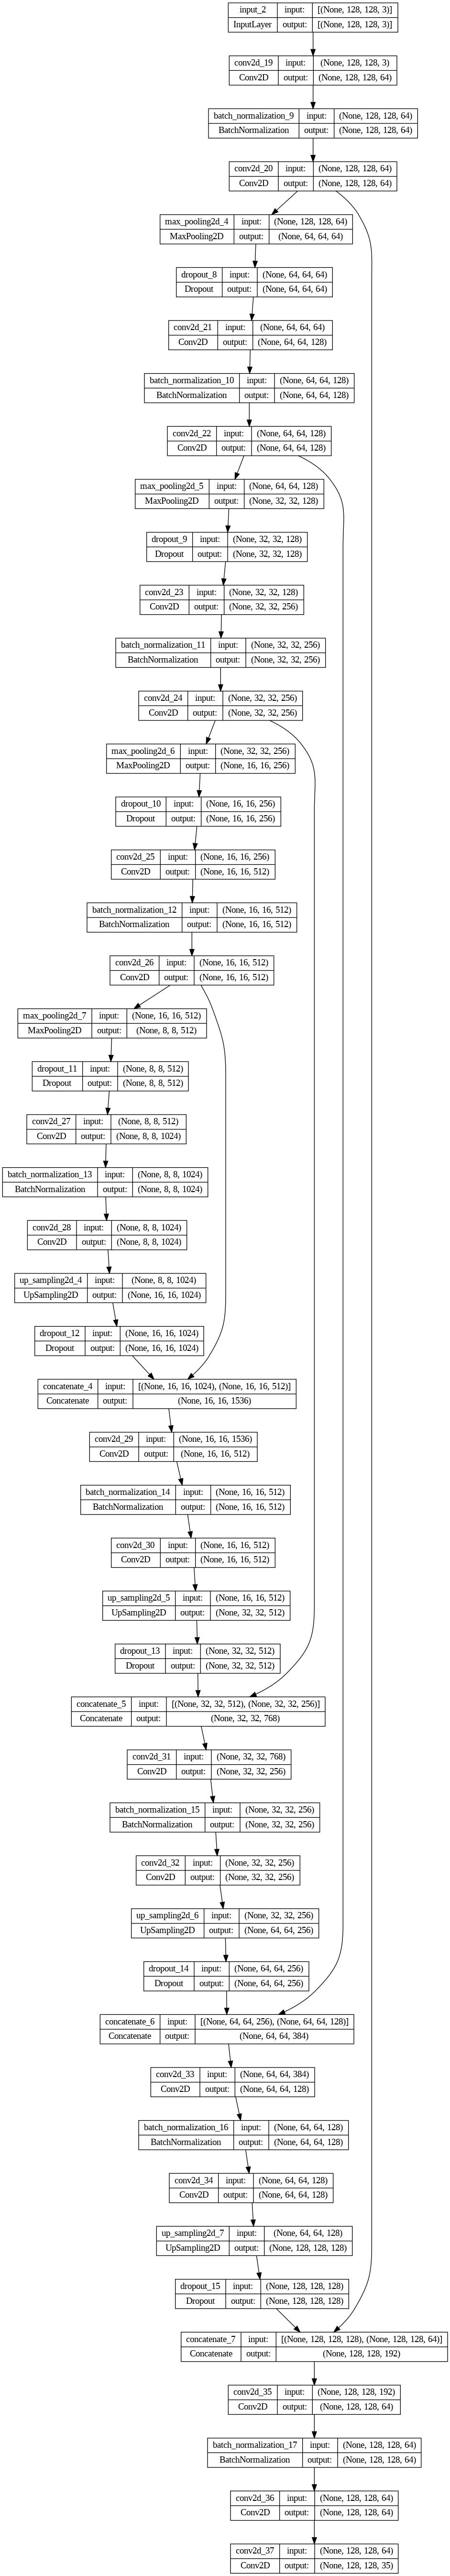

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True,show_layer_names = True, to_file = "model2.jpg")

### 3.2. Utility Metrics and Callbacks classes

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
                y_true=None,
                y_pred=None,
                num_classes=None,
                name=None,ignore_class=None,
                dtype=None,sparse_y_true = True,sparse_y_pred = True, axis = -1):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype,)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None,):
        if (epoch % 5 == 0):

            img, mask, _ = preprocess(os.path.join(self.file_path),IMAGE_SIZE)
            pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
            pred = np.squeeze(np.argmax(pred, axis=-1))

            tmp1 = np.zeros([mask.shape[0], mask.shape[1], 3])
            tmp2 = np.zeros([mask.shape[0], mask.shape[1], 3])


            for row in range(mask.shape[0]):
                for col in range(mask.shape[1]):
                    tmp1[row, col, :] = id2color[mask[row, col]]
                    tmp1 = tmp1.astype('uint8')

                    tmp2[row, col, :] = id2color[pred[row, col]]
                    tmp2 = tmp2.astype('uint8')

            fig, axes = plt.subplots(nrows = 1, ncols = 2)
            axes[0].imshow(tmp1, cmap='viridis')
            axes[0].set_title("Original Mask")
            axes[1].imshow(tmp2, cmap='viridis')
            axes[1].set_title("Predicted Mask")
            axes[0].grid(False)
            axes[1].grid(False)
            plt.tight_layout()
            plt.show()

class SaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
        self.max_iou: float = 0

    def on_epoch_end(self, epoch, logs=None,):
        if (epoch % 10 == 0 and logs['val_accuracy'] > self.max_iou):
            self.max_iou = logs['val_accuracy']
            model.save(self.file_path + f"/epoch{epoch:<4d}_({logs['val_mean_iou']:.4f}).h5")
            print(f"\tSave epoch{epoch:<4d} val_mean_iou: ({logs['val_mean_iou']:.4f}).h5")

def plot_history(history):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
    # Training
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1), y=history.history["loss"], ax = axes[0], label="Training Loss")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["accuracy"], ax = axes[1], label="Training Accuracy")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

    # Validation
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1),y= history.history["val_loss"], ax = axes[0], label="Validation Loss")
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1),y= history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1),y= history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")

    axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Mean IOU")
    plt.tight_layout()
    plt.show()

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam",
                metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True,)
viz_callback = VizCallback(val_path + "/10.jpg")
save_callback = SaveCallback(path + "/model_save/checkpoint_for_each_epoch")

### 3.3. Model Training

Epoch 1/100
 6/95 [>.............................] - ETA: 47s - loss: 2.4932 - accuracy: 0.3708 - mean_iou: 0.0413

1/1 [==============================] - 0s 263ms/step


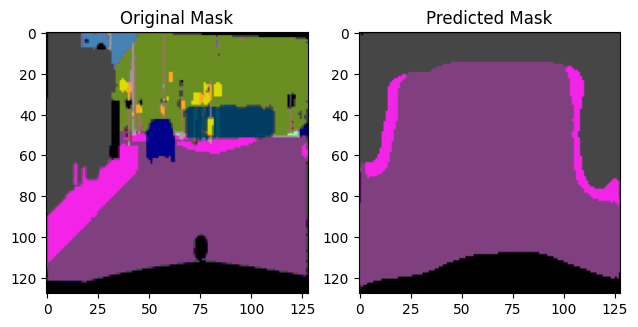

95/95 [==============================] - 65s 588ms/step - loss: 1.1666 - accuracy: 0.6845 - mean_iou: 0.1102 - val_loss: 2.9322 - val_accuracy: 0.4499 - val_mean_iou: 0.0444
Epoch 2/100
95/95 [==============================] - 55s 577ms/step - loss: 0.8651 - accuracy: 0.7642 - mean_iou: 0.1845 - val_loss: 1.9339 - val_accuracy: 0.5326 - val_mean_iou: 0.0634
Epoch 3/100
95/95 [==============================] - 55s 576ms/step - loss: 0.7875 - accuracy: 0.7857 - mean_iou: 0.2084 - val_loss: 2.2828 - val_accuracy: 0.5502 - val_mean_iou: 0.0598
Epoch 4/100
95/95 [==============================] - 55s 581ms/step - loss: 0.7216 - accuracy: 0.8027 - mean_iou: 0.2254 - val_loss: 2.0208 - val_accuracy: 0.5731 - val_mean_iou: 0.0691
Epoch 5/100
95/95 [==============================] - 55s 578ms/step - loss: 0.6852 - accuracy: 0.8115 - mean_iou: 0.2409 - val_loss: 1.7105 - val_accuracy: 0.6128 - val_mean_iou: 0.0884
Epoch 6/100
1/1 [==============================] - 0s 20ms/step


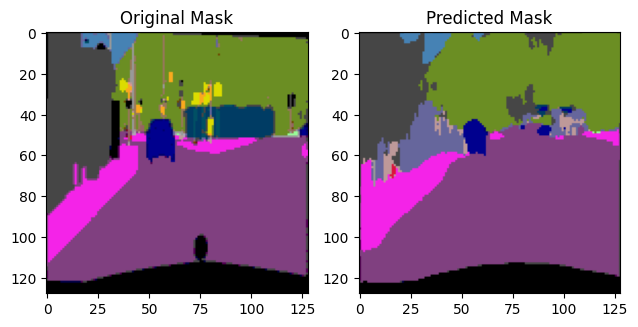

95/95 [==============================] - 55s 583ms/step - loss: 0.6396 - accuracy: 0.8223 - mean_iou: 0.2576 - val_loss: 1.0432 - val_accuracy: 0.7400 - val_mean_iou: 0.1666
Epoch 7/100
95/95 [==============================] - 55s 577ms/step - loss: 0.6237 - accuracy: 0.8254 - mean_iou: 0.2667 - val_loss: 0.8356 - val_accuracy: 0.7814 - val_mean_iou: 0.2116
Epoch 8/100
95/95 [==============================] - 55s 576ms/step - loss: 0.5990 - accuracy: 0.8309 - mean_iou: 0.2823 - val_loss: 0.7425 - val_accuracy: 0.8042 - val_mean_iou: 0.2330
Epoch 9/100
95/95 [==============================] - 55s 579ms/step - loss: 0.5755 - accuracy: 0.8361 - mean_iou: 0.2949 - val_loss: 0.7759 - val_accuracy: 0.7838 - val_mean_iou: 0.2330
Epoch 10/100
95/95 [==============================] - 55s 575ms/step - loss: 0.5656 - accuracy: 0.8381 - mean_iou: 0.2997 - val_loss: 0.7599 - val_accuracy: 0.7973 - val_mean_iou: 0.2442
Epoch 11/100
1/1 [==============================] - 0s 23ms/step


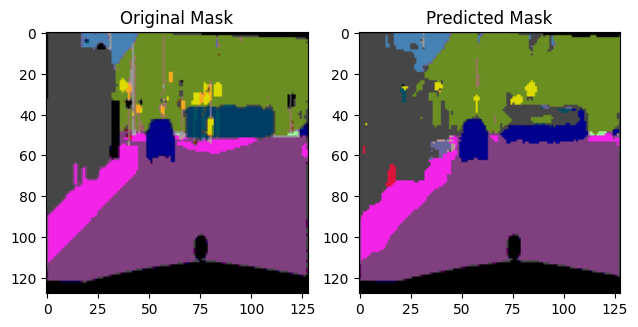

95/95 [==============================] - 55s 583ms/step - loss: 0.5441 - accuracy: 0.8435 - mean_iou: 0.3141 - val_loss: 0.6463 - val_accuracy: 0.8183 - val_mean_iou: 0.2661
Epoch 12/100
95/95 [==============================] - 55s 576ms/step - loss: 0.5351 - accuracy: 0.8459 - mean_iou: 0.3256 - val_loss: 0.6601 - val_accuracy: 0.8224 - val_mean_iou: 0.2684
Epoch 13/100
95/95 [==============================] - 55s 579ms/step - loss: 0.5198 - accuracy: 0.8501 - mean_iou: 0.3382 - val_loss: 0.7091 - val_accuracy: 0.8040 - val_mean_iou: 0.2589
Epoch 14/100
95/95 [==============================] - 55s 579ms/step - loss: 0.5067 - accuracy: 0.8536 - mean_iou: 0.3474 - val_loss: 0.6702 - val_accuracy: 0.8137 - val_mean_iou: 0.2686
Epoch 15/100
95/95 [==============================] - 55s 579ms/step - loss: 0.4969 - accuracy: 0.8559 - mean_iou: 0.3535 - val_loss: 0.6942 - val_accuracy: 0.8083 - val_mean_iou: 0.2777
Epoch 16/100
1/1 [==============================] - 0s 22ms/step


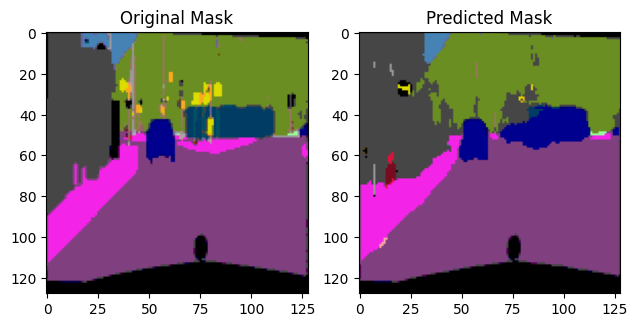

95/95 [==============================] - 56s 586ms/step - loss: 0.4857 - accuracy: 0.8589 - mean_iou: 0.3624 - val_loss: 0.6209 - val_accuracy: 0.8318 - val_mean_iou: 0.2877
Epoch 17/100
95/95 [==============================] - 55s 579ms/step - loss: 0.4653 - accuracy: 0.8650 - mean_iou: 0.3815 - val_loss: 0.6576 - val_accuracy: 0.8179 - val_mean_iou: 0.2961
Epoch 18/100
95/95 [==============================] - 55s 576ms/step - loss: 0.4640 - accuracy: 0.8650 - mean_iou: 0.3840 - val_loss: 0.6327 - val_accuracy: 0.8283 - val_mean_iou: 0.2960
Epoch 19/100
95/95 [==============================] - 55s 578ms/step - loss: 0.4604 - accuracy: 0.8664 - mean_iou: 0.3880 - val_loss: 0.6684 - val_accuracy: 0.8234 - val_mean_iou: 0.2843
Epoch 20/100
95/95 [==============================] - 55s 575ms/step - loss: 0.4419 - accuracy: 0.8714 - mean_iou: 0.4034 - val_loss: 0.5993 - val_accuracy: 0.8340 - val_mean_iou: 0.3090
Epoch 21/100
1/1 [==============================] - 0s 20ms/step


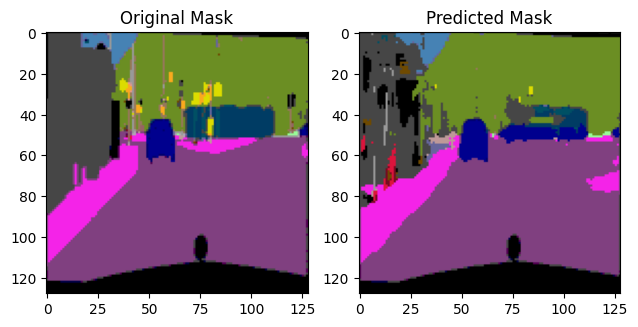

95/95 [==============================] - 56s 585ms/step - loss: 0.4328 - accuracy: 0.8735 - mean_iou: 0.4134 - val_loss: 0.6251 - val_accuracy: 0.8310 - val_mean_iou: 0.2964
Epoch 22/100
95/95 [==============================] - 55s 575ms/step - loss: 0.4292 - accuracy: 0.8747 - mean_iou: 0.4192 - val_loss: 0.6446 - val_accuracy: 0.8214 - val_mean_iou: 0.3017
Epoch 23/100
95/95 [==============================] - 55s 578ms/step - loss: 0.4232 - accuracy: 0.8762 - mean_iou: 0.4201 - val_loss: 0.6298 - val_accuracy: 0.8323 - val_mean_iou: 0.3068
Epoch 24/100
95/95 [==============================] - 55s 578ms/step - loss: 0.4182 - accuracy: 0.8776 - mean_iou: 0.4280 - val_loss: 0.6731 - val_accuracy: 0.8071 - val_mean_iou: 0.3023
Epoch 25/100
95/95 [==============================] - 55s 575ms/step - loss: 0.4049 - accuracy: 0.8813 - mean_iou: 0.4360 - val_loss: 0.5937 - val_accuracy: 0.8405 - val_mean_iou: 0.3197
Epoch 26/100
1/1 [==============================] - 0s 20ms/step


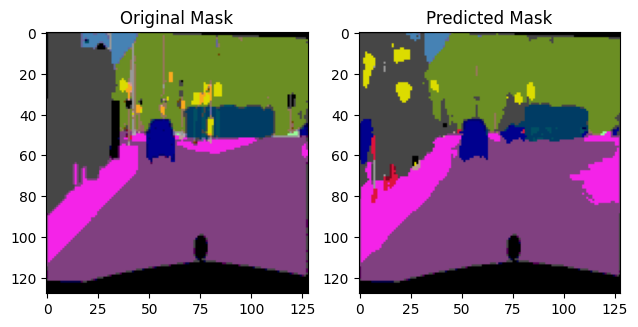

95/95 [==============================] - 55s 585ms/step - loss: 0.3947 - accuracy: 0.8842 - mean_iou: 0.4526 - val_loss: 0.6681 - val_accuracy: 0.8325 - val_mean_iou: 0.3023
Epoch 27/100
95/95 [==============================] - 55s 575ms/step - loss: 0.3945 - accuracy: 0.8843 - mean_iou: 0.4534 - val_loss: 0.6045 - val_accuracy: 0.8373 - val_mean_iou: 0.3105
Epoch 28/100
95/95 [==============================] - 55s 578ms/step - loss: 0.3867 - accuracy: 0.8863 - mean_iou: 0.4607 - val_loss: 0.6171 - val_accuracy: 0.8425 - val_mean_iou: 0.3250
Epoch 29/100
95/95 [==============================] - 54s 574ms/step - loss: 0.3756 - accuracy: 0.8894 - mean_iou: 0.4706 - val_loss: 0.6066 - val_accuracy: 0.8427 - val_mean_iou: 0.3225
Epoch 30/100
95/95 [==============================] - 54s 573ms/step - loss: 0.3633 - accuracy: 0.8930 - mean_iou: 0.4851 - val_loss: 0.6007 - val_accuracy: 0.8406 - val_mean_iou: 0.3275
Epoch 31/100
1/1 [==============================] - 0s 19ms/step


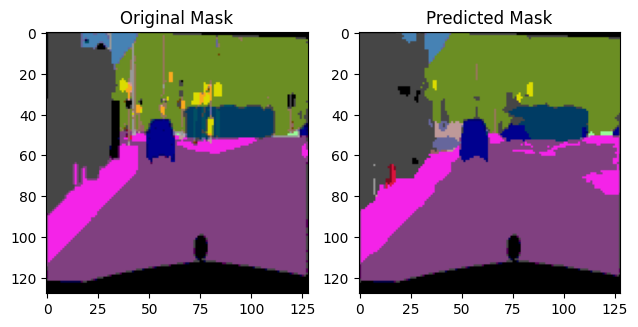

95/95 [==============================] - 55s 584ms/step - loss: 0.3528 - accuracy: 0.8958 - mean_iou: 0.4962 - val_loss: 0.6490 - val_accuracy: 0.8323 - val_mean_iou: 0.3255
Epoch 32/100
95/95 [==============================] - 55s 575ms/step - loss: 0.3584 - accuracy: 0.8943 - mean_iou: 0.4930 - val_loss: 0.6808 - val_accuracy: 0.8319 - val_mean_iou: 0.3182
Epoch 33/100
95/95 [==============================] - 55s 574ms/step - loss: 0.3545 - accuracy: 0.8954 - mean_iou: 0.4941 - val_loss: 0.6191 - val_accuracy: 0.8406 - val_mean_iou: 0.3258
Epoch 34/100
95/95 [==============================] - 55s 577ms/step - loss: 0.3387 - accuracy: 0.8997 - mean_iou: 0.5116 - val_loss: 0.6167 - val_accuracy: 0.8470 - val_mean_iou: 0.3258
Epoch 35/100
95/95 [==============================] - 55s 574ms/step - loss: 0.3322 - accuracy: 0.9014 - mean_iou: 0.5191 - val_loss: 0.6068 - val_accuracy: 0.8457 - val_mean_iou: 0.3413


In [ ]:
history = model.fit(x=train_images, y=train_masks_enc, epochs = 100, batch_size = BATCH_SIZE,
                    validation_data = (val_images, val_masks_enc) ,
                    callbacks = [viz_callback, early_stopping])

### 3.4. Training Result

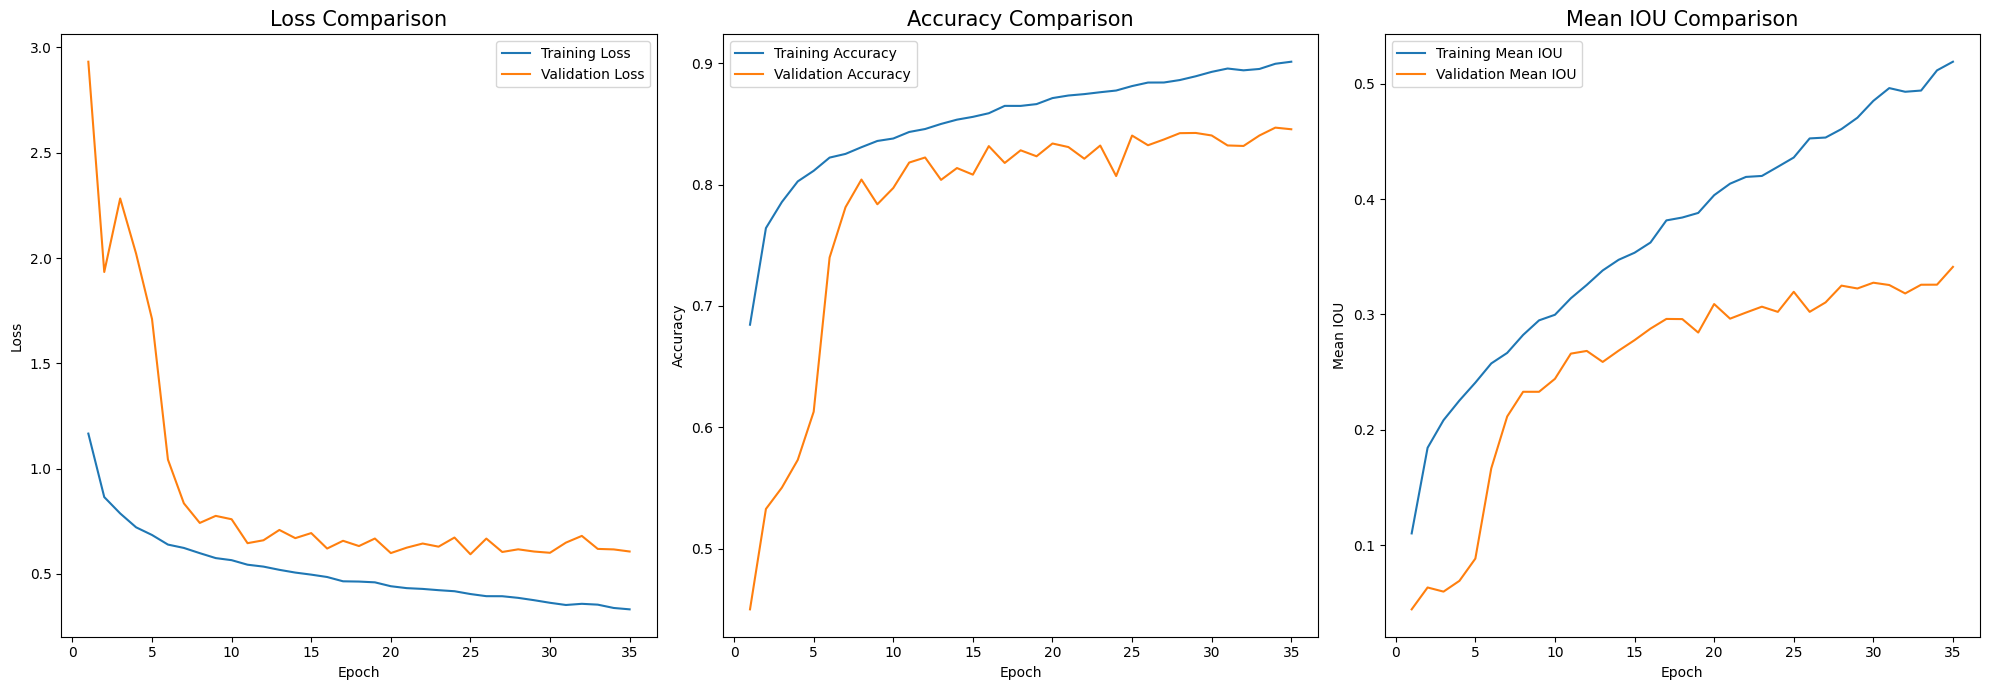

In [ ]:
plot_history(history)

### 3.5. Save model

In [ ]:
model.save(os.path.join(path,'model_save/Unet_model35.h5'))

###3.6. Load model

In [ ]:
# model_path = os.path.join(path,'mode_save/checkpoint_for_each_epoch/')
model_path = os.path.join(path,'model_save/Unet_model35.h5')
# model = tf.keras.models.load_model(model_path,)
with tf.keras.utils.custom_object_scope({'UpdatedMeanIoU': UpdatedMeanIoU}):
    model = tf.keras.models.load_model(model_path)

1/1 [==============================] - 0s 23ms/step


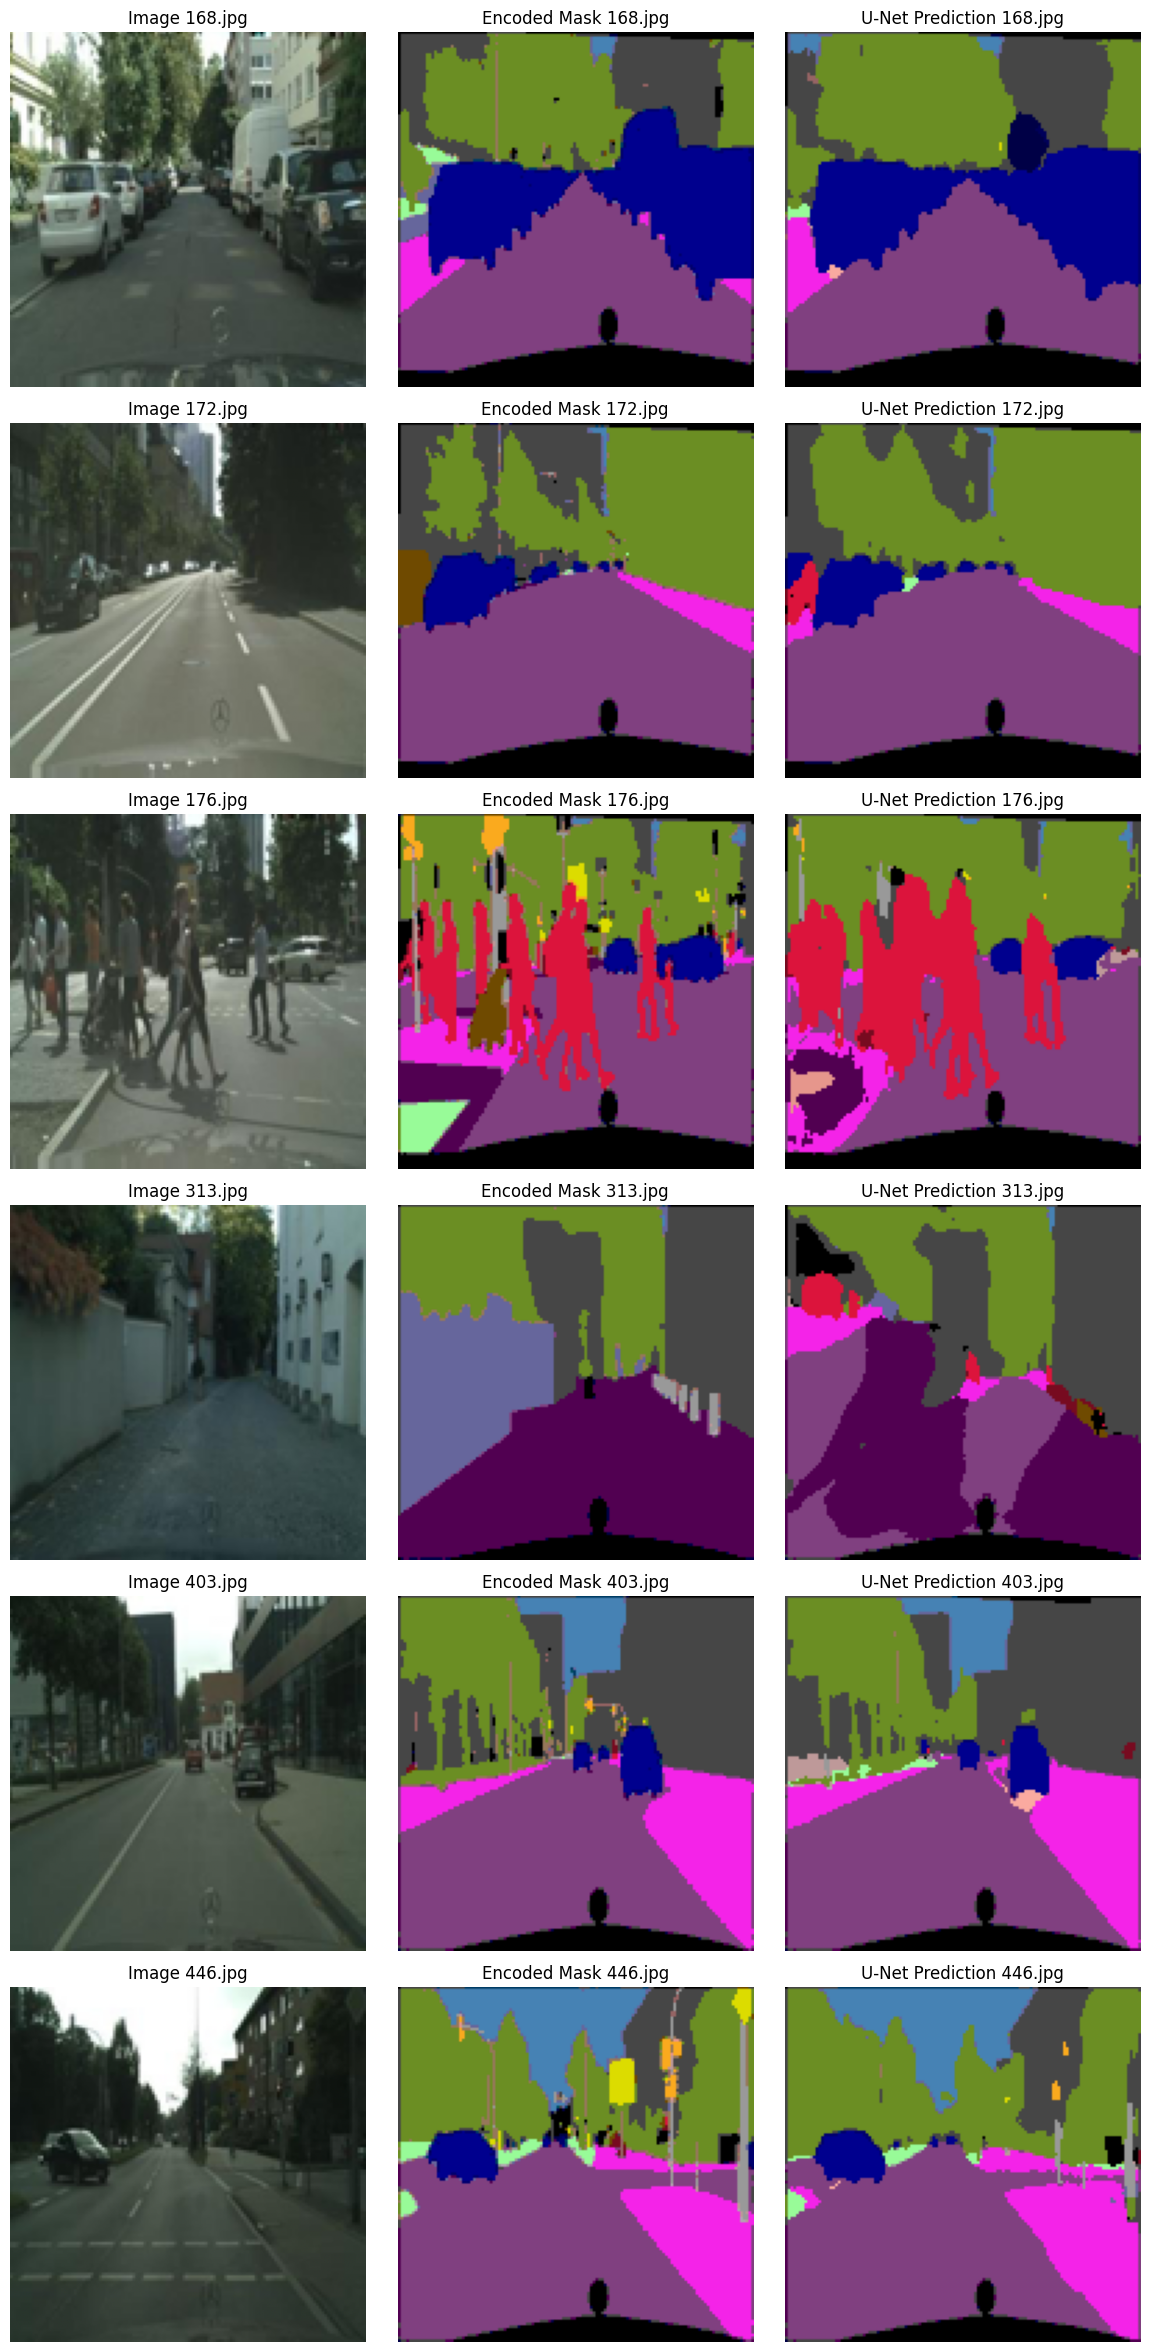

In [ ]:
plt.style.use("default")
samples = [168, 172, 176, 313, 403, 446]
plt.figure(figsize=[15, len(samples) * 5])
names = [f'{_}.jpg' for _ in samples]
for i, name in enumerate(names):
# for i, name in enumerate(os.listdir(val_path)[:4]):
    img, mask, _ = preprocess(os.path.join(val_path,name),IMAGE_SIZE)
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp1 = np.zeros([mask.shape[0], mask.shape[1], 3])
    tmp2 = np.zeros([mask.shape[0], mask.shape[1], 3])


    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            tmp1[row, col, :] = id2color[mask[row, col]]
            tmp1 = tmp1.astype('uint8')

            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(len(samples), 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(name))

    plt.subplot(len(samples), 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(name))

    plt.subplot(len(samples), 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('U-Net Prediction {}'.format(name))
    mpimg.imsave(f'predict_{i}.jpg',tmp2)
    plt.savefig(f'pic{i}.jpg')
    # plt.close()



plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('pic.jpg')

<a class="anchor" id="4" name="4"></a>
## **4. Model Evaluation**

Model Evaluation is an integral part of the model development process. It helps to find the best model that represents our data and how well the chosen model will work in the future. For classification tasks, precision and recall are the popular choice metrics used in addition with model accuracy to evaluate model performance since model accuracy is not always sufficient to judge if a model is optimal or not (especially if our dataset is skewed). The same rule applies to most dense prediction tasks like image segmentation where the goal is to simplify and/or change the representation of an image into classes that is more meaningful and easier to analyze.


Since the goal of our model is to partition an input image into various classes, it is often difficult to know if our model struggles to optimally partition one or more classes since it doesn't always reflect in the model accuracy, neither can it easily detected by the eyes. Hence, there is a need for supplementary metrics to evaluate model performance.

In this project, we will be using recall,precision, specificity, true detection rate (TDR), Intersection over Union (IoU), and F1-score as supplementary metrics to evaluate our model performance. These metrics were computed by identifying the variables true positive (TP), true negative (TN), false positive (FP), and false-negative (FN) by calculating the confusion matrix between the predicted segmentations and the ground truth segmentations. The expressions for these metrics are defined as:

1. Precision = TP/(TP + FP)
2. Recall/Sensitivity = TP/(TP + FN)
3. Specificity = TN/(TN + FP)
4. True Detection Rate (TDR) = 1 - (FN/(TP + FN))
5. Intersection over Union (IoU)/Jaccard Similarity  = TP/(TP + FP + FN)
6. F1-score(JS)/Dice coefficient = 2 * ((Precision * Recall)/(Precision + Recall))

<br/>

To carry out these evaluations, we will:
1. Create segmentations/masks of images in our dataset
2. Evaluate predicted segmentations


<a class="anchor" id="4-1" name="4-1"></a>
### **4.1. Create Segmentations/Masks of Images in our Dataset**

In [ ]:
def create_mask(image_data,mask_data, model):
    true_masks, predicted_masks = [], []
    for images, masks in zip(image_data, mask_data):
        pred_masks = model.predict(images.reshape([1] + IMAGE_SHAPE))
        pred_masks = tf.squeeze(tf.argmax(pred_masks, axis=-1))
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)

    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)

    return true_masks, predicted_masks

In [ ]:
true_train_masks, predicted_train_masks = create_mask(train_images,train_masks_enc, model)

In [ ]:
true_validation_masks, predicted_validation_masks = create_mask(val_images, val_masks_enc, model)

1/1 [==============================] - 0s 20ms/step


<a class="anchor" id="4-2" name="4-2"></a>
### **4.2. Evaluate Predicted Segmentations**

In [ ]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):

    """
    Evaluates semantic segmentation model

    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division

    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric
                                outputs the for each segmentation class
        overall_evaluations: a dictionary containing evaluation metric
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[]
    class_wise_specificities, class_wise_ious = [],[]
    class_wise_tdrs, class_wise_f1_scores = [],[]
    class_wise_dices = []
    classes, classes_name = [], []

    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0

        number_of_masks = true_masks.shape[0]

        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))

            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        dice = round(2 * true_positives/(2 * true_positives + false_negatives + false_positives + smooth), 2)

        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        class_wise_dices.append(dice)
        classes.append("Class " + str(clas+1))
        classes_name.append(labels[clas].name)
        # class_wise_pixel_accuracies.append(pixel_accuracy)

    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)
    mean_dice = round(np.average(np.array(class_wise_dices)), 2)


    class_wise_evaluations = {"Class": classes,
                              "Name": classes_name,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "Dice": class_wise_dices,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                           "Name": "All",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "Dice": mean_dice,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}

    evaluations = {"Overall Evaluations": overall_evaluations,
                   "Class-wise Evaluations": class_wise_evaluations}

    return evaluations

In [ ]:
def show_evaluations(evaluations,
                     metrics=["Recall", "Precision", "Specificity", "IoU", "Dice", "TDR", "F1 Score"],
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics

        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """

    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]

    # Validate list of metrics
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'")

    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. "
                             "List is either shorter or longer than segmentation classes")
    else:
        class_list = [class_wise_evaluations["Class"]]
        class_name = [class_wise_evaluations["Name"]]

    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"], "All"] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + class_name + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()

    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")


    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class", "Name"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)

    return dataframe

#### **4.2.1. Evaluate predicted segmentations of the training images**

In [ ]:
true_train_masks.shape,predicted_train_masks.shape

In [ ]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=num_classes)

show_evaluations(model_evaluation_on_train_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

#### **4.2.2. Evaluate predicted segmentations of the validation images**

In [ ]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=num_classes)

In [ ]:
# full metrics=["Recall", "Precision", "Specificity", "IoU", "Dice", "TDR", "F1-Score"],
df = show_evaluations(model_evaluation_on_validation_dataset,
                 metrics=["IoU", "Dice"],
                 class_list=None,
                 display_evaluations="All")

df
# df.sort_values(by='IoU', ascending=False, ignore_index=True)

,Class,Name,IoU,Dice
0,All Classes,All,0.26,0.35
1,Class 1,unlabeled,0.82,0.9
2,Class 2,ego vehicle,0.0,0.0
3,Class 3,rectification border,0.0,0.0
4,Class 4,out of roi,0.0,0.0
5,Class 5,static,0.0,0.0
6,Class 6,dynamic,0.02,0.03
7,Class 7,ground,0.21,0.35
8,Class 8,road,0.89,0.94
9,Class 9,sidewalk,0.59,0.74


# Test

In [ ]:
def segment_url(url):
    urllib.request.urlretrieve(url, 'test.png')
    img = cv2.imread('test.png')
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # normalize input image
    img = np.array(img) / 255
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp2 = np.zeros([img.shape[0], img.shape[1], 3])

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(tmp2)
    plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

1/1 [==============================] - 0s 27ms/step


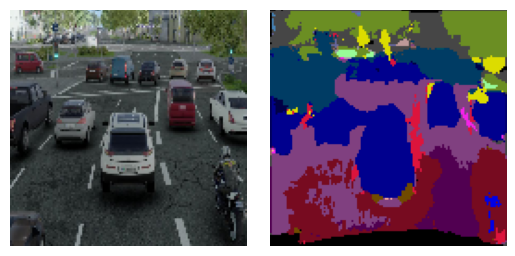

In [ ]:
segment_url('https://www.cognata.com/wp-content/uploads/2020/01/slide3b-1.jpg')

In [ ]:
import gradio as gr

def predict(img):
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # normalize input image
    img = np.array(img) / 255
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp2 = np.zeros([img.shape[0], img.shape[1], 3])

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')
    return tmp2

gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Image(type="pil"),
             examples=["lion.jpg", "cheetah.jpg"]).launch()